<a href="https://colab.research.google.com/github/leonsuarez24/Notebooks/blob/main/Dataset_Contensation_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torch
from torch.utils.data import Dataset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
!pip install torchinfo
from torchinfo import summary
import copy
import torch.optim as optim

# Parameters

In [23]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
dataset = 'SVHN'
ipc = 10 # image(s) per class
num_eval = 20 # the number of evaluating randomly initialized models
epoch_eval_train = 300 # epochs to train a model with synthetic data
Iteration = 1000 # training iterations
lr_img = 0.1 # learning rate for updating synthetic images
lr_net = 0.01 # learning rate for updating network parameters
batch_real = 256 # batch size for real data
batch_train = 256 # batch size for training networks

# Utils

In [24]:
class TensorDataset(Dataset):
    def __init__(self, images, labels): # images: n x c x h x w tensor
        self.images = images.detach().float()
        self.labels = labels.detach()

    def __getitem__(self, index):
        return self.images[index], self.labels[index]

    def __len__(self):
        return self.images.shape[0]

In [25]:
def get_dataset(dataset, data_path='./data'):
    if dataset == 'MNIST':
        channel = 1
        im_size = (28, 28)
        num_classes = 10
        mean = [0.1307]
        std = [0.3081]
        transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=mean, std=std)])
        dst_train = datasets.MNIST(data_path, train=True, download=True, transform=transform) # no augmentation
        dst_test = datasets.MNIST(data_path, train=False, download=True, transform=transform)
        class_names = [str(c) for c in range(num_classes)]

    elif dataset == 'FashionMNIST':
        channel = 1
        im_size = (28, 28)
        num_classes = 10
        mean = [0.2861]
        std = [0.3530]
        transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=mean, std=std)])
        dst_train = datasets.FashionMNIST(data_path, train=True, download=True, transform=transform) # no augmentation
        dst_test = datasets.FashionMNIST(data_path, train=False, download=True, transform=transform)
        class_names = dst_train.classes

    elif dataset == 'SVHN':
        channel = 3
        im_size = (32, 32)
        num_classes = 10
        mean = [0.4377, 0.4438, 0.4728]
        std = [0.1980, 0.2010, 0.1970]
        transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=mean, std=std)])
        dst_train = datasets.SVHN(data_path, split='train', download=True, transform=transform)  # no augmentation
        dst_test = datasets.SVHN(data_path, split='test', download=True, transform=transform)
        class_names = [str(c) for c in range(num_classes)]

    elif dataset == 'CIFAR10':
        channel = 3
        im_size = (32, 32)
        num_classes = 10
        mean = [0.4914, 0.4822, 0.4465]
        std = [0.2023, 0.1994, 0.2010]
        transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=mean, std=std)])
        dst_train = datasets.CIFAR10(data_path, train=True, download=True, transform=transform) # no augmentation
        dst_test = datasets.CIFAR10(data_path, train=False, download=True, transform=transform)
        class_names = dst_train.classes

    else:
        exit('unknown dataset: %s'%dataset)

    testloader = torch.utils.data.DataLoader(dst_test, batch_size=256, shuffle=False, num_workers=2)
    return channel, im_size, num_classes, class_names, mean, std, dst_train, dst_test, testloader

In [32]:
def get_loops(ipc):
    # Get the two hyper-parameters of outer-loop and inner-loop.
    # The following values are empirically good.
    if ipc == 1:
        outer_loop, inner_loop = 1, 1
    elif ipc == 10:
        outer_loop, inner_loop = 10, 50
    elif ipc == 20:
        outer_loop, inner_loop = 20, 25
    elif ipc == 30:
        outer_loop, inner_loop = 30, 20
    elif ipc == 40:
        outer_loop, inner_loop = 40, 15
    elif ipc == 50:
        outer_loop, inner_loop = 50, 10
    else:
        outer_loop, inner_loop = 0, 0
        exit('DC error: loop hyper-parameters are not defined for %d ipc'%ipc)
    return outer_loop, inner_loop

In [27]:
def get_images(c, n): # get random n images from class c
    idx_shuffle = np.random.permutation(indices_class[c])[:n]
    return images_all[idx_shuffle]

In [28]:
def epoch(mode, dataloader, net, optimizer, criterion, device):
    loss_avg, acc_avg, num_exp = 0, 0, 0
    net = net.to(device)
    criterion = criterion.to(device)

    if mode == 'train':
        net.train()
    else:
        net.eval()

    for i_batch, datum in enumerate(dataloader):
        img = datum[0].float().to(device)
        lab = datum[1].long().to(device)
        n_b = lab.shape[0]

        output = net(img)
        loss = criterion(output, lab)
        acc = np.sum(np.equal(np.argmax(output.cpu().data.numpy(), axis=-1), lab.cpu().data.numpy()))

        loss_avg += loss.item()*n_b
        acc_avg += acc
        num_exp += n_b

        if mode == 'train':
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    loss_avg /= num_exp
    acc_avg /= num_exp

    return loss_avg, acc_avg

In [29]:
def evaluate_synset(net, images_train, labels_train, testloader, learningrate, batchsize_train, device, Epoch = 600):
    net = net.to(device)
    images_train = images_train.to(device)
    labels_train = labels_train.to(device)
    lr = float(learningrate)
    lr_schedule = [Epoch//2+1]
    optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=0.0005)
    criterion = nn.CrossEntropyLoss().to(device)

    dst_train = TensorDataset(images_train, labels_train)
    trainloader = torch.utils.data.DataLoader(dst_train, batch_size=batchsize_train, shuffle=True, num_workers=0)

    for ep in range(Epoch+1):
        loss_train, acc_train = epoch('train', trainloader, net, optimizer, criterion, device)
        if ep in lr_schedule:
            lr *= 0.1
            optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=0.0005)

    loss_test, acc_test = epoch('test', testloader, net, optimizer, criterion, device)
    print('Evaluate: epoch = %04d, train loss = %.6f, train acc = %.4f, test acc = %.4f' % (Epoch, loss_train, acc_train, acc_test))

    return net, acc_train, acc_test

# Match loss

In [33]:
def distance_wb(gwr, gws):
    shape = gwr.shape
    if len(shape) == 4: # conv, out*in*h*w
        gwr = gwr.reshape(shape[0], shape[1] * shape[2] * shape[3])
        gws = gws.reshape(shape[0], shape[1] * shape[2] * shape[3])
    elif len(shape) == 3:  # layernorm, C*h*w
        gwr = gwr.reshape(shape[0], shape[1] * shape[2])
        gws = gws.reshape(shape[0], shape[1] * shape[2])
    elif len(shape) == 2: # linear, out*in
        tmp = 'do nothing'
    elif len(shape) == 1: # batchnorm/instancenorm, C; groupnorm x, bias
        gwr = gwr.reshape(1, shape[0])
        gws = gws.reshape(1, shape[0])
        return 0

    dis_weight = torch.sum(1 - torch.sum(gwr * gws, dim=-1) / (torch.norm(gwr, dim=-1) * torch.norm(gws, dim=-1) + 0.000001))
    dis = dis_weight
    return dis

def match_loss(gw_syn, gw_real):
    dis = torch.tensor(0.0).to(device)
    for ig in range(len(gw_real)):
        dis += distance_wb(gw_real[ig], gw_syn[ig])
    return dis

# Network

In [34]:
class LeNet(nn.Module):
    def __init__(self, channel, num_classes):
        super(LeNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(channel, 6, kernel_size=5, padding=2 if channel==1 else 0),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(6, 16, kernel_size=5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.fc_1 = nn.Linear(16 * 5 * 5, 120)
        self.fc_2 = nn.Linear(120, 84)
        self.fc_3 = nn.Linear(84, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc_1(x))
        x = F.relu(self.fc_2(x))
        x = self.fc_3(x)
        return x

''' ConvNet '''
class ConvNet(nn.Module):
    def __init__(self, channel, num_classes, net_width, net_depth, net_act, net_norm, net_pooling, im_size = (32,32)):
        super(ConvNet, self).__init__()
        if net_act == 'sigmoid':
            self.net_act = nn.Sigmoid()
        elif net_act == 'relu':
            self.net_act = nn.ReLU(inplace=True)
        elif net_act == 'leakyrelu':
            self.net_act = nn.LeakyReLU(negative_slope=0.01)
        else:
            exit('unknown activation function: %s'%net_act)

        if net_pooling == 'maxpooling':
            self.net_pooling = nn.MaxPool2d(kernel_size=2, stride=2)
        elif net_pooling == 'avgpooling':
            self.net_pooling = nn.AvgPool2d(kernel_size=2, stride=2)
        elif net_pooling == 'none':
            self.net_pooling = None
        else:
            exit('unknown net_pooling: %s'%net_pooling)

        self.features, shape_feat = self._make_layers(channel, net_width, net_depth, net_norm, net_pooling, im_size)
        num_feat = shape_feat[0]*shape_feat[1]*shape_feat[2]
        self.classifier = nn.Linear(num_feat, num_classes)

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

    def _get_normlayer(self, net_norm, shape_feat):
        # shape_feat = (c*h*w)
        if net_norm == 'batchnorm':
            norm = nn.BatchNorm2d(shape_feat[0], affine=True)
        elif net_norm == 'layernorm':
            norm = nn.LayerNorm(shape_feat, elementwise_affine=True)
        elif net_norm == 'instancenorm':
            norm = nn.GroupNorm(shape_feat[0], shape_feat[0], affine=True)
        elif net_norm == 'groupnorm':
            norm = nn.GroupNorm(4, shape_feat[0], affine=True)
        elif net_norm == 'none':
            norm = None
        else:
            norm = None
            exit('unknown net_norm: %s'%net_norm)
        return norm

    def _make_layers(self, channel, net_width, net_depth, net_norm, net_pooling, im_size):
        layers = []
        in_channels = channel
        if im_size[0] == 28:
            im_size = (32, 32)
        shape_feat = [in_channels, im_size[0], im_size[1]]
        for d in range(net_depth):
            layers += [nn.Conv2d(in_channels, net_width, kernel_size=3, padding=3 if channel == 1 and d == 0 else 1)]
            shape_feat[0] = net_width
            if net_norm != 'none':
                layers += [self._get_normlayer(net_norm, shape_feat)]
            layers += [self.net_act]
            in_channels = net_width
            if net_pooling != 'none':
                layers += [self.net_pooling]
                shape_feat[1] //= 2
                shape_feat[2] //= 2

        return nn.Sequential(*layers), shape_feat

In [35]:
net_width, net_depth, net_act, net_norm, net_pooling = 128, 3, 'relu', 'instancenorm', 'avgpooling'
network = ConvNet(1,10,net_width, net_depth, net_act, net_norm, net_pooling).to(device)
summary(network, (32,1,32,32))

Layer (type:depth-idx)                   Output Shape              Param #
ConvNet                                  [32, 10]                  --
├─Sequential: 1-1                        [32, 128, 4, 4]           --
│    └─Conv2d: 2-1                       [32, 128, 36, 36]         1,280
│    └─GroupNorm: 2-2                    [32, 128, 36, 36]         256
│    └─ReLU: 2-3                         [32, 128, 36, 36]         --
│    └─AvgPool2d: 2-4                    [32, 128, 18, 18]         --
│    └─Conv2d: 2-5                       [32, 128, 18, 18]         147,584
│    └─GroupNorm: 2-6                    [32, 128, 18, 18]         256
│    └─ReLU: 2-7                         [32, 128, 18, 18]         --
│    └─AvgPool2d: 2-8                    [32, 128, 9, 9]           --
│    └─Conv2d: 2-9                       [32, 128, 9, 9]           147,584
│    └─GroupNorm: 2-10                   [32, 128, 9, 9]           256
│    └─ReLU: 2-11                        [32, 128, 9, 9]           --

#Dataset

In [36]:
outer_loop, inner_loop = get_loops(ipc) # Get the two hyper-parameters of outer-loop and inner-loop

In [37]:
channel, im_size, num_classes, class_names, mean, std, dst_train, dst_test, testloader = get_dataset(dataset)

Using downloaded and verified file: ./data/train_32x32.mat
Using downloaded and verified file: ./data/test_32x32.mat


In [38]:
images_all = []
labels_all = []
indices_class = [[] for c in range(num_classes)]

images_all = [torch.unsqueeze(dst_train[i][0], dim=0) for i in range(len(dst_train))] # Save the images (1,1,28,28)
labels_all = [dst_train[i][1] for i in range(len(dst_train))] # Save the labels

In [39]:
for i, lab in enumerate(labels_all): # Save the index of each class labels
    indices_class[lab].append(i)
images_all = torch.cat(images_all, dim=0).to(device) # Cat images along the batch dimension
labels_all = torch.tensor(labels_all, dtype=torch.long, device=device) # Make the labels a tensor

for c in range(num_classes):
    print('class c = %d: %d real images'%(c, len(indices_class[c]))) # Prints how many labels are for each class

class c = 0: 4948 real images
class c = 1: 13861 real images
class c = 2: 10585 real images
class c = 3: 8497 real images
class c = 4: 7458 real images
class c = 5: 6882 real images
class c = 6: 5727 real images
class c = 7: 5595 real images
class c = 8: 5045 real images
class c = 9: 4659 real images


# Initialize syntethic images as noise

In [41]:
# Initialize syntethic data as noise, ipc = images per class
image_syn = torch.randn(size=(num_classes*ipc, channel, im_size[0], im_size[1]), dtype=torch.float, requires_grad=True, device=device)
label_syn = torch.tensor([np.ones(ipc)*i for i in range(num_classes)], dtype=torch.long, requires_grad=False, device=device).view(-1) # [0,0,0, 1,1,1, ..., 9,9,9]

## Training

In [42]:
optimizer_img = torch.optim.SGD([image_syn, ], lr=lr_img, momentum=0.5) # optimizer_img for synthetic data
optimizer_img.zero_grad()
criterion = nn.CrossEntropyLoss().to(device) # Loss function

In [43]:
for it in range(Iteration+1):
    ''' Train synthetic data '''
    net = ConvNet(channel,num_classes, net_width, net_depth, net_act, net_norm, net_pooling).to(device)
    net.train()
    net_parameters = list(net.parameters())
    optimizer_net = torch.optim.SGD(net.parameters(), lr=lr_net, momentum=0.5)  # optimizer_img for synthetic data
    optimizer_net.zero_grad()
    loss_avg = 0

    for ol in range(outer_loop):

        ''' update synthetic data '''
        loss = torch.tensor(0.0).to(device)
        for c in range(num_classes):
            img_real = get_images(c, batch_real)
            lab_real = torch.ones((img_real.shape[0],), device=device, dtype=torch.long) * c
            output_real = net(img_real)
            loss_real = criterion(output_real, lab_real)
            gw_real = torch.autograd.grad(loss_real, net_parameters)
            gw_real = list((_.detach().clone() for _ in gw_real))

            img_syn = image_syn[c*ipc:(c+1)*ipc].reshape((ipc, channel, im_size[0], im_size[1]))
            lab_syn = torch.ones((ipc,), device=device, dtype=torch.long) * c
            output_syn = net(img_syn)
            loss_syn = criterion(output_syn, lab_syn)
            gw_syn = torch.autograd.grad(loss_syn, net_parameters, create_graph=True)

            loss += match_loss(gw_syn, gw_real)

        optimizer_img.zero_grad()
        loss.backward()
        optimizer_img.step()
        loss_avg += loss.item()

        if ol == outer_loop - 1:
            break

        ''' update network '''
        image_syn_train, label_syn_train = copy.deepcopy(image_syn.detach()), copy.deepcopy(label_syn.detach())  # avoid any unaware modification
        dst_syn_train = TensorDataset(image_syn_train, label_syn_train)
        trainloader = torch.utils.data.DataLoader(dst_syn_train, batch_size=batch_train, shuffle=True, num_workers=0)
        for il in range(inner_loop):
            epoch('train', trainloader, net, optimizer_net, criterion, device)

    loss_avg /= (num_classes*outer_loop)
    if it%10 == 0:
        print('iter = %04d, loss = %.4f' % (it, loss_avg))

iter = 0000, loss = 261.1343
iter = 0010, loss = 217.2560
iter = 0020, loss = 202.2863
iter = 0030, loss = 192.8032
iter = 0040, loss = 186.1453
iter = 0050, loss = 180.4228
iter = 0060, loss = 170.6300
iter = 0070, loss = 168.8484
iter = 0080, loss = 165.5908
iter = 0090, loss = 161.0228
iter = 0100, loss = 160.6510
iter = 0110, loss = 155.9903
iter = 0120, loss = 154.9701
iter = 0130, loss = 151.7577
iter = 0140, loss = 153.6205
iter = 0150, loss = 146.5586
iter = 0160, loss = 149.9463
iter = 0170, loss = 146.7076
iter = 0180, loss = 139.6244
iter = 0190, loss = 141.2614
iter = 0200, loss = 139.2793
iter = 0210, loss = 137.6289
iter = 0220, loss = 136.6602
iter = 0230, loss = 134.6900
iter = 0240, loss = 136.4890
iter = 0250, loss = 136.9651
iter = 0260, loss = 133.6998
iter = 0270, loss = 134.7904
iter = 0280, loss = 135.9019
iter = 0290, loss = 132.5212
iter = 0300, loss = 129.6061
iter = 0310, loss = 131.9064
iter = 0320, loss = 131.7331
iter = 0330, loss = 128.2195
iter = 0340, l

KeyboardInterrupt: ignored

In [46]:
accs = []
for it_eval in range(num_eval):
    net_eval = ConvNet(channel,num_classes, net_width, net_depth, net_act, net_norm, net_pooling).to(device)  # get a random model (initialize a network)
    image_syn_eval, label_syn_eval = copy.deepcopy(image_syn.detach()), copy.deepcopy(label_syn.detach()) # avoid any unaware modification
    # Trains a model in syntethic data, epoch_eval_train = 1000
    _, acc_train, acc_test = evaluate_synset(net_eval, image_syn_eval, label_syn_eval, testloader, lr_net, batch_train, device, epoch_eval_train)
    accs.append(acc_test)


Evaluate: epoch = 0300, train loss = 0.004042, train acc = 1.0000, test acc = 0.7454
Evaluate: epoch = 0300, train loss = 0.003993, train acc = 1.0000, test acc = 0.7412
Evaluate: epoch = 0300, train loss = 0.004135, train acc = 1.0000, test acc = 0.7424
Evaluate: epoch = 0300, train loss = 0.004037, train acc = 1.0000, test acc = 0.7380
Evaluate: epoch = 0300, train loss = 0.004069, train acc = 1.0000, test acc = 0.7601
Evaluate: epoch = 0300, train loss = 0.004007, train acc = 1.0000, test acc = 0.7428
Evaluate: epoch = 0300, train loss = 0.004047, train acc = 1.0000, test acc = 0.7488
Evaluate: epoch = 0300, train loss = 0.004264, train acc = 1.0000, test acc = 0.7359
Evaluate: epoch = 0300, train loss = 0.004286, train acc = 1.0000, test acc = 0.7490
Evaluate: epoch = 0300, train loss = 0.004005, train acc = 1.0000, test acc = 0.7544
Evaluate: epoch = 0300, train loss = 0.004026, train acc = 1.0000, test acc = 0.7429
Evaluate: epoch = 0300, train loss = 0.003945, train acc = 1.0000

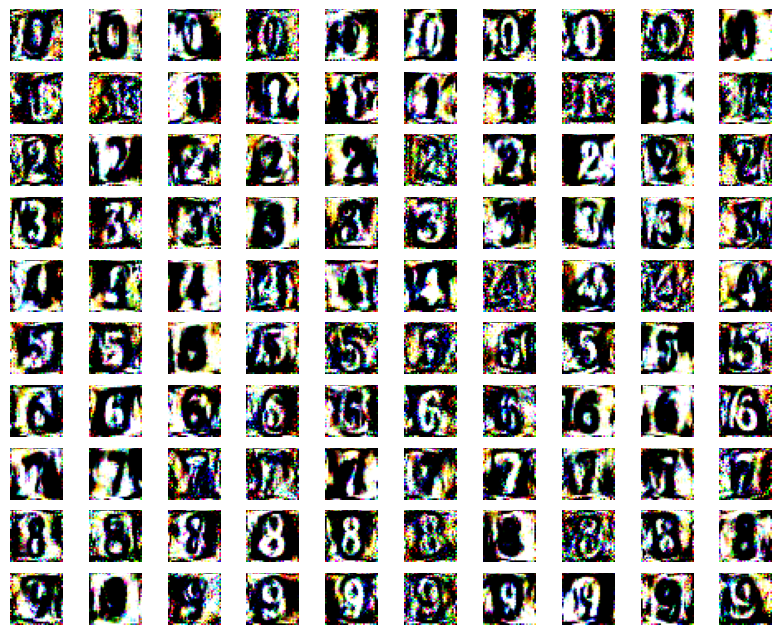

In [45]:
def print_syn_img():
    fig, axes = plt.subplots(ipc,num_classes, figsize=(10, 8))

    images_print, labels_print = copy.deepcopy(image_syn.detach()).cpu().detach().numpy(), copy.deepcopy(label_syn.detach()).cpu().detach().numpy()
    images_print = images_print.transpose(0,2,3,1)
    if ipc==1:

        for i in range(num_classes):
            axes[i].imshow(images_print[i], cmap='gray')
            axes[i].axis('off')

    else:
        k=0
        for i in range(num_classes):
            for j in range(ipc):
                axes[i,j].imshow(images_print[k], cmap='gray')
                axes[i,j].axis('off')
                k+=1
print_syn_img()